In [1]:
# ---------------------------
# 1) Setup & Imports
# ---------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score,
    roc_auc_score, roc_curve
)

# Optional (install if available)
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except:
    XGB_AVAILABLE = False

try:
    import shap
    SHAP_AVAILABLE = True
except:
    SHAP_AVAILABLE = False

RANDOM_STATE = 42
pd.set_option('display.max_columns', 200)


In [3]:
# ---------------------------
# 2) Load Dataset
# ---------------------------
DATA_PATH = r"C:\Users\hp\Downloads\bank+marketing\bank\bank-full.csv"  # download from UCI if not present

if not os.path.exists(DATA_PATH):
    print("Download 'bank-full.csv' from UCI repository and place in folder.")
else:
    df = pd.read_csv(DATA_PATH, sep=";")
    print("Loaded dataset with shape:", df.shape)

df.head()


Loaded dataset with shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Target distribution:
y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

Missing values per column:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Numeric summary:
            count         mean          std     min    25%    50%     75%  \
age       45211.0    40.936210    10.618762    18.0   33.0   39.0    48.0   
balance   45211.0  1362.272058  3044.765829 -8019.0   72.0  448.0  1428.0   
day       45211.0    15.806419     8.322476     1.0    8.0   16.0    21.0   
duration  45211.0   258.163080   257.527812     0.0  103.0  180.0   319.0   
campaign  45211.0     2.763841     3.098021     1.0    1.0    2.0     3.0   
pdays     45211.0    40.197828   100.128746    -1.0   -1.0   -1.0    -1.0   
previous  45211.0     0.580323     2.303441     0.0    0.0 

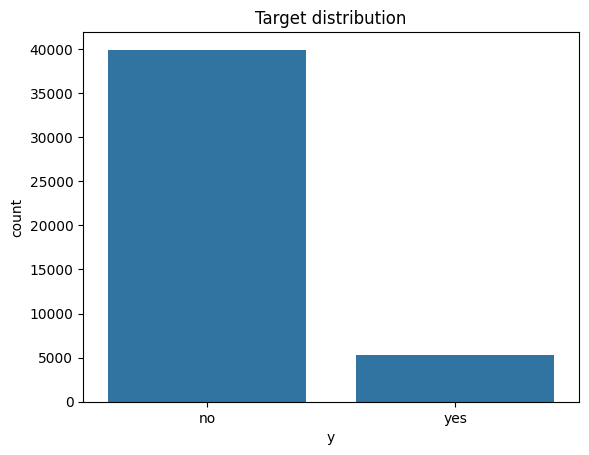

In [4]:
# ---------------------------
# 3) Basic EDA
# ---------------------------
print("Target distribution:")
print(df['y'].value_counts(normalize=True))

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nNumeric summary:")
print(df.describe().T)

# Visualization examples
sns.countplot(x="y", data=df)
plt.title("Target distribution")
plt.show()


In [6]:
# ---------------------------
# 4) Preprocessing
# ---------------------------
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols.remove("y")
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

X = df.drop(columns=["y"])
y = df["y"].map({"yes": 1, "no": 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numeric columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Train size: (36168, 16) Test size: (9043, 16)


In [7]:
# ---------------------------
# 5) Modeling
# ---------------------------
pipe_lr = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE))
])

pipe_rf = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))
])

models = {"LogisticRegression": pipe_lr, "RandomForest": pipe_rf}

if XGB_AVAILABLE:
    pipe_xgb = Pipeline([
        ("pre", preprocessor),
        ("clf", xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE))
    ])
    models["XGBoost"] = pipe_xgb

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)


Training LogisticRegression...
Training RandomForest...



---- LogisticRegression ----
              precision    recall  f1-score   support

           0     0.9719    0.8498    0.9068      7985
           1     0.4182    0.8147    0.5527      1058

    accuracy                         0.8457      9043
   macro avg     0.6951    0.8323    0.7298      9043
weighted avg     0.9071    0.8457    0.8654      9043

Confusion Matrix:
 [[6786 1199]
 [ 196  862]]
F1-score: 0.5527412632253927
ROC AUC: 0.9079218714674134


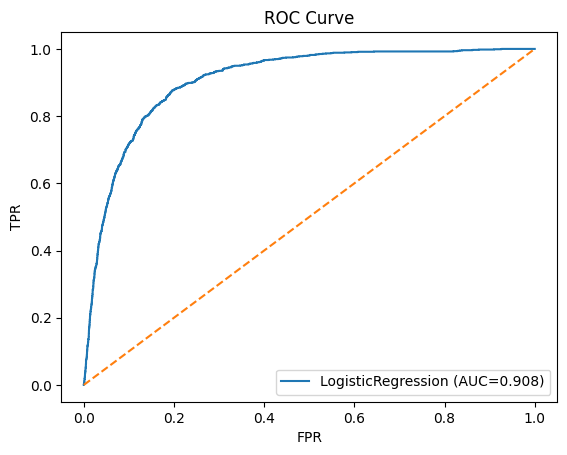


---- RandomForest ----
              precision    recall  f1-score   support

           0     0.9257    0.9727    0.9486      7985
           1     0.6662    0.4112    0.5085      1058

    accuracy                         0.9070      9043
   macro avg     0.7960    0.6919    0.7286      9043
weighted avg     0.8954    0.9070    0.8971      9043

Confusion Matrix:
 [[7767  218]
 [ 623  435]]
F1-score: 0.5084745762711864
ROC AUC: 0.9280597599705497


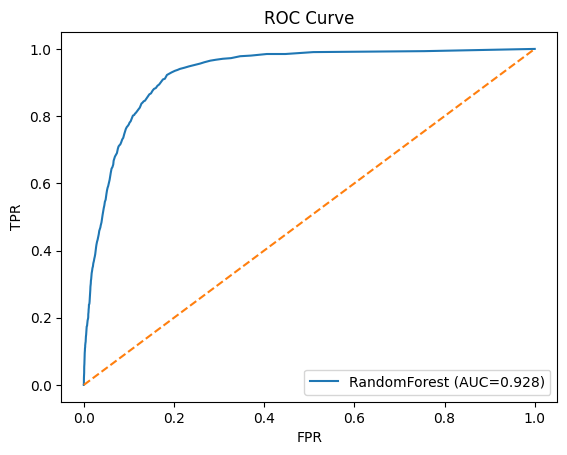

In [8]:
# ---------------------------
# 6) Evaluation
# ---------------------------
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    try:
        y_proba = model.predict_proba(X_test)[:,1]
    except:
        y_proba = None

    print("\n----", name, "----")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))

    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        print("ROC AUC:", auc)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
        plt.plot([0,1],[0,1],"--")
        plt.legend()
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title("ROC Curve")
        plt.show()

for name, model in models.items():
    evaluate_model(name, model, X_test, y_test)


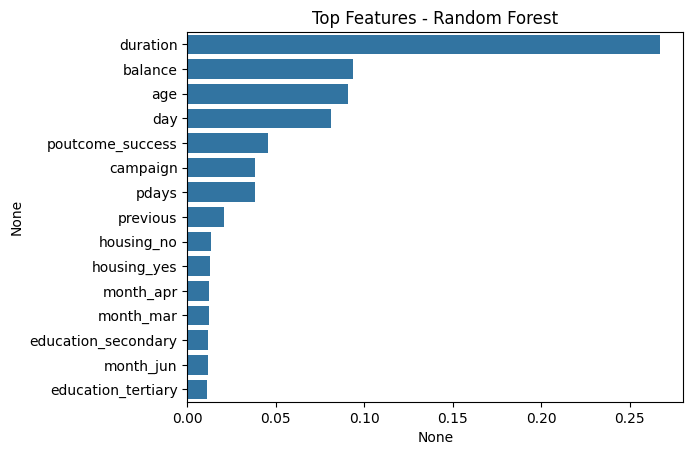

In [9]:
# ---------------------------
# 7) Feature Importance
# ---------------------------
def get_feature_names(preprocessor):
    num_features = num_cols
    cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
    return list(num_features) + list(cat_features)

feature_names = get_feature_names(preprocessor.fit(X_train))

if "RandomForest" in models:
    rf = models["RandomForest"].named_steps["clf"]
    importances = pd.Series(rf.feature_importances_, index=feature_names)
    top_features = importances.sort_values(ascending=False).head(15)

    sns.barplot(x=top_features, y=top_features.index)
    plt.title("Top Features - Random Forest")
    plt.show()
